implementation of colorectal cancer paper methods on lung cancer dataset

Colorectal paper utilized a Random Forest to rank the import features. These were then normalized

ZZfeature map which applies a hadamard gate to create superposition and rotations around the z axis to encode feature values into quantum states. Cnot gates are also used for entanglement.

In [1]:
from qiskit.circuit.library import ZZFeatureMap

feature_dim = 8  #number of qubits
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1) #reps=2 repeats the feature mapping twice

QSVM maps data into high dimensional Hilbert space. Inner product of quantum features maps create the decision boundary
$
k(x_{i},x_{j}) = |\left\langle \varphi(x_{i})|\varphi(x_{j}) \right\rangle|^{2}
$

In [2]:
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute

sampler = Sampler()
state_fidelity = ComputeUncompute(sampler)
quantum_kernel = FidelityQuantumKernel(fidelity=state_fidelity)

C:\Users\joeyh\AppData\Local\Temp\ipykernel_21356\550734137.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


Now we will load our data

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

np.random.seed(1234)
df = pd.read_csv('cancer_dataset.csv')

#convert bool to int
df['test'] = df['test'].astype(int)
df['inSlab'] = df['inSlab'].astype(int)
df['belPl'] = df['belPl'].astype(int)
df['outBx'] = df['outBx'].astype(int)
#drop id column
df = df.drop(columns=["id"], errors="ignore")

X = df.drop(columns=["ca", "Stage"])  # features
y = df["ca"]  # target labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

#stage column (I,II,III,IV) needs to be changed into numerical values
if "Stage" in X_train.columns:
    encoder = LabelEncoder()
    X_train["Stage"] = encoder.fit_transform(X_train["Stage"])
    X_test["Stage"] = encoder.transform(X_test["Stage"])


print("training size", X_train.shape, y_train.shape)
print("testing size", X_test.shape, y_test.shape)

training size (280, 411) (280,)
testing size (70, 411) (70,)


Training a random forest classifier to do feature selection as too many features is too computationally expensive

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feature_importances = rf.feature_importances_
top_features = np.argsort(feature_importances)[::-1][:feature_dim]  # number of qubits must match number of features
selected_feature_names = X_train.columns[top_features]
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]
# X_train_selected = X_train.iloc[:, top_features]
# X_test_selected = X_test.iloc[:, top_features]
print("training size", X_train_selected.shape, y_train.shape)
print("testing size", X_test_selected.shape, y_test.shape)
print("Columns in X_train:", X_train_selected.columns)
print("Selected Features:", selected_feature_names)


training size (280, 8) (280,)
testing size (70, 8) (70,)
Columns in X_train: Index(['ZPC17', 'test', 'ZPC30', 'belPl', 'ZPC11', 'ZPC6', 'ZPC9', 'ZPC7'], dtype='object')
Selected Features: Index(['ZPC17', 'test', 'ZPC30', 'belPl', 'ZPC11', 'ZPC6', 'ZPC9', 'ZPC7'], dtype='object')


Test with classical svm

In [5]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

svm = SVC(kernel="rbf")  # no apparent difference from sigmoid
svm.fit(X_train_scaled, y_train)
y_pred = svm.predict(X_test_scaled)
print("Classical SVM Accuracy:", accuracy_score(y_test, y_pred))

Classical SVM Accuracy: 0.7714285714285715


Back to testing the Quantum SVM

In [ ]:
from qiskit_machine_learning.algorithms import QSVC
qsvc = QSVC(quantum_kernel=quantum_kernel, verbose=True)
print("fitting model")
# Final QSVC Fit
qsvc.fit(X_train_scaled, y_train)
print("model trained")

y_pred_qsvc = qsvc.predict(X_test_scaled)
qsvc_accuracy = accuracy_score(y_test,y_pred_qsvc)
print("qsvm accuracy: ", qsvc_accuracy)

fitting model
[LibSVM]model trained


Graphing the comparison of QSVM and classical SVM

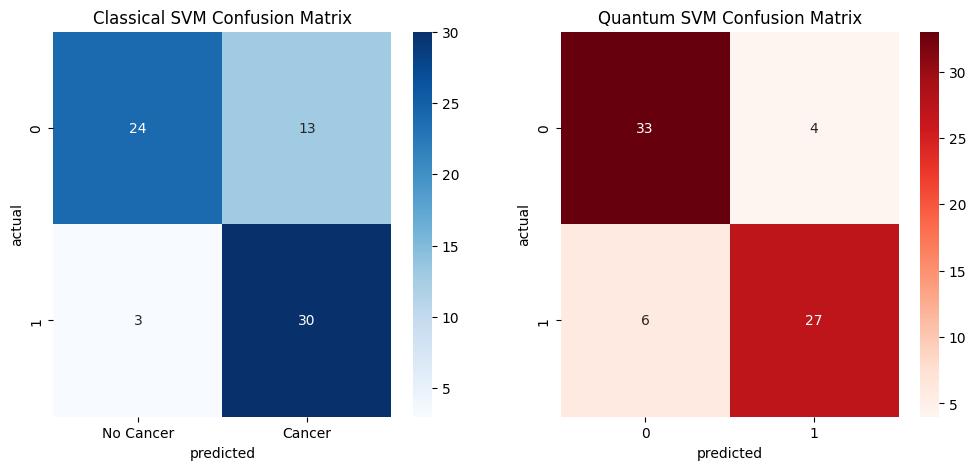

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_svm = confusion_matrix(y_test, y_pred)
cm_qsvc = confusion_matrix(y_test, y_pred_qsvc)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", ax=axes[0], xticklabels=["No Cancer", "Cancer"])
axes[0].set_title("Classical SVM Confusion Matrix")
axes[0].set_xlabel("predicted")
axes[0].set_ylabel("actual")
sns.heatmap(cm_qsvc, annot=True, fmt="d", cmap="Reds", ax=axes[1])
axes[1].set_title("Quantum SVM Confusion Matrix")
axes[1].set_xlabel("predicted")
axes[1].set_ylabel("actual")

plt.show()

Out of curiosity, I played around with other Quantum simulated methods of learning and predicting the data

In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
# Hybrid QNN implementation - my research indicated that a hybrid implementation is better on larger datasets
import torch
from sklearn.preprocessing import StandardScaler
from qiskit import QuantumCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch.nn as nn
import torch.optim as optim
from qiskit.circuit import ParameterVector

num_qubits = 12  


#tensorize
top_features = np.argsort(feature_importances)[::-1][:num_qubits]  # number of qubits must match number of features
selected_feature_names = X_train.columns[top_features]
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device) #needed to make sure shape works
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)


def create_quantum_circuit(num_qubits):
    qc = QuantumCircuit(num_qubits)
    input_params = ParameterVector("x", num_qubits)
    weight_params = ParameterVector("theta", num_qubits)

    for i in range(num_qubits):
        qc.h(i)  # apply Hadamard for superposition
        qc.rx(input_params[i], i)
        qc.ry(weight_params[i], i) #rotation gates
    for i in range(num_qubits - 1): #adding entanglement with Cnot gates... trying to improve accuracy
        qc.cx(i, i + 1)
    return qc, input_params, weight_params
#this I found online as I did not know how to create a hybrid QNN
class HybridQNN(nn.Module):
    def __init__(self, qnn_layer):
        super().__init__()
        self.qnn = qnn_layer  # quantum layer
        self.fc = nn.Sequential(nn.Linear(1,24), nn.ReLU(), nn.Linear(24,12), 
        nn.ReLU(), nn.Linear(12,6), nn.ReLU(), nn.Linear(6,1))  # classic layer
    #processes via a quantum then linear layer. outputs via sigmoid with continous prob from 0 to 1
    def forward(self, x):
        x = self.qnn(x)  # quantum version
        x = self.fc(x)   # classic version
        return x  # output prob

# create the qnn
qc, input_p, weight_p = create_quantum_circuit(num_qubits)
qc.draw("mpl")
qnn = EstimatorQNN(circuit=qc, input_params=input_p, weight_params=weight_p)
qnn_layer = TorchConnector(qnn)

#model creation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HybridQNN(qnn_layer).to(device)  # model on gpu if possible
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"epoch: {epoch}: loss = {loss.item():.4f}")

with torch.no_grad():
    y_pred_test = model(X_test_tensor)
y_pred_binary = (y_pred_test > 0.5).float()
qnn_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), y_pred_binary.cpu().numpy()) #numpy has to run on cpu
print("QNN accuracy:", qnn_accuracy)

C:\Users\joeyh\AppData\Local\Temp\ipykernel_21356\3295176917.py:56: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(circuit=qc, input_params=input_p, weight_params=weight_p)


epoch: 0: loss = 0.6932
epoch: 1: loss = 0.6931
epoch: 2: loss = 0.6931
epoch: 3: loss = 0.6931
epoch: 4: loss = 0.6931
epoch: 5: loss = 0.6931
epoch: 6: loss = 0.6930
epoch: 7: loss = 0.6930
epoch: 8: loss = 0.6931
epoch: 9: loss = 0.6931
epoch: 10: loss = 0.6931
epoch: 11: loss = 0.6931
epoch: 12: loss = 0.6931
epoch: 13: loss = 0.6930
epoch: 14: loss = 0.6930
epoch: 15: loss = 0.6931
epoch: 16: loss = 0.6931
epoch: 17: loss = 0.6931
epoch: 18: loss = 0.6931
epoch: 19: loss = 0.6930
QNN accuracy: 0.5285714285714286


Classification Report:
               precision    recall  f1-score   support

         0.0       0.53      1.00      0.69        37
         1.0       0.00      0.00      0.00        33

    accuracy                           0.53        70
   macro avg       0.26      0.50      0.35        70
weighted avg       0.28      0.53      0.37        70



c:\Users\joeyh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\joeyh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\joeyh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

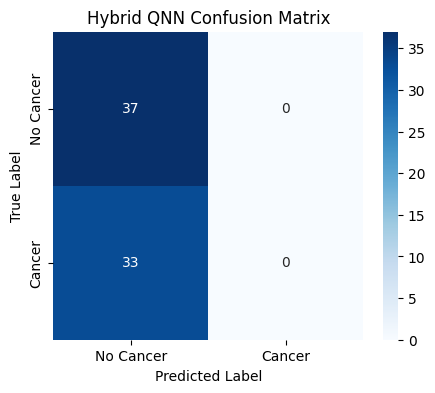

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

y_test_np = y_test_tensor.cpu().numpy()
y_pred_np = y_pred_binary.cpu().numpy()

conf_matrix = confusion_matrix(y_test_np, y_pred_np)

print("Classification Report:\n", classification_report(y_test_np, y_pred_np))
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Hybrid QNN Confusion Matrix")
plt.show()